# Load Libraries 

In [1]:
import sys
import re
from os import listdir
from os.path import isfile, join
import math
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
def ph_depend(pH_list, pH_data, num):
    """
    pH_list: List of pH_values used for Analysis. 
    pH_data: Multidimensional list with all stored data. 
        num: The specific data that you want from your pH_data. 
    """
    ph_depend_data = []
    for n, pH in enumerate(pH_list):
        datum = []
        for dat in pH_data[n]:
            datum.append(dat[num])
        ph_depend_data.append([pH, np.mean(datum), np.std(datum)])
    return ph_depend_data

In [3]:
def mindist(sel1, sel2):
    list_o_dist = []
    for a in sel1:
        for b in sel2:
            p1 = a.position
            p2 = b.position
            dist = math.sqrt((p2[2]-p1[2])**2+(p2[1]-p1[1])**2+(p2[0]-p1[0])**2)
            list_o_dist.append(dist)
    return min(list_o_dist) 

# Paths to Files and pH range

In [4]:
path = "/home/jackh/plasmepsin/hbonds_to_dyad/holo/data"
phs = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5]
sstage = 21
lstage = 42
stages = [x for x in range(sstage, lstage+1)]

# Load Data

In [5]:
# specifically for loading plasmepsin data
D34_data  = []
D214_data = []
for ph in phs:
    D34_data_sub  = []
    D214_data_sub = []
    for i in stages:
        with open('{}/pH_{}_stage{}.dat'.format(path, ph, i), 'r') as f:
            for line in f:
                if '#' not in line:
                    sl = re.split('\s+', line)
                    sl = sl[:-1]
                    l1 = [0, 1, 2, 5, 6, 7, 8, 15]
                    l2 = [0, 3, 4, 9, 10, 11, 12, 13, 14, 16]
                    D34_data_sub.append([float(sl[x]) for x in l1])
                    D214_data_sub.append([float(sl[x]) for x in l2])
    D34_data.append(D34_data_sub)
    D214_data.append(D214_data_sub)                

# Perform H-Bond Count Analysis

In [6]:
hb_cut = 2.4
ucut   = 0.8
lcut   = 0.2

## D34 Interactions

Considers Lambda

In [7]:
D34_final = []
D34_lig_final = []
for n, ph in enumerate(phs):
    total    = 0
    HB_count = 0
    HB_l_count = 0
    for frame, dat in enumerate(D34_data[n]):
        if (dat[1] >= ucut or dat[1] <= lcut) and (dat[2] >= ucut or dat[2] <= lcut): # Check no Mix
            total += 1
        if dat[1] >= ucut and (dat[2] >= ucut or dat[2] <= lcut): # Check no Mix
            if dat[3] <= hb_cut: # D34:OD*-S37:HG1
                HB_count += 1
                HB_l_count += 1
            if dat[4] <= hb_cut: # D34:OD*-G36:HN
                HB_count += 1
                HB_l_count += 1
            if dat[5] <= hb_cut: # D34:OD*-T35:HN
                HB_count += 1
                HB_l_count += 1
            if dat[6] <= hb_cut and D214_data[n][frame][0] <= 0.2: # D34:OD*-D214:HD* make sure D214 is protonated, does not consider taut.
                HB_count += 1
                HB_l_count += 1
            if dat[7] <= hb_cut:
                HB_l_count += 1
    #print('{0} {1} {2:0.2f}'.format(HB_count, total, HB_count/total))
    D34_final.append([ph, HB_count/total])
    D34_lig_final.append([ph, HB_l_count/total])

Doesn't Consider Lambda

D34_final = []
for n, ph in enumerate(phs):
    total    = 0
    HB_count = 0
    for frame, dat in enumerate(D34_data[n]):
        total += 1
        if dat[3] <= hb_cut: # D34:OD*-S37:HG1
            HB_count += 1
        if dat[4] <= hb_cut: # D34:OD*-G36:HN
            HB_count += 1 
        if dat[5] <= hb_cut: # D34:OD*-T35:HN
            HB_count += 1
        if dat[6] <= hb_cut and D214_data[n][frame][0] <= 0.2: # D34:OD*-D214:HD* make sure D214 is protonated, does not consider taut.
            HB_count += 1
    #print('{0} {1} {2:0.2f}'.format(HB_count, total, HB_count/total))
    D34_final.append([ph, HB_count/total])

## D214 Considerations

Considers Lambda

In [8]:
D214_final = []
D214_lig_final = []
for n, ph in enumerate(phs):
    total    = 0
    HB_count = 0
    HB_l_count = 0
    for frame, dat in enumerate(D214_data[n]):
        if (dat[1] >= ucut or dat[1] <= lcut) and (dat[2] >= ucut or dat[2] <= lcut): # Check no Mix
            total += 1
        if dat[1] >= ucut and (dat[2] >= ucut or dat[2] <= lcut): # Check no Mix
            if dat[3] <= hb_cut:
                HB_count += 1 # D214:OD*-T35:HG1
                HB_l_count += 1
            if dat[4] <= hb_cut:
                HB_count += 1 # D214:OD*-S215:HN
                HB_l_count += 1
            if dat[5] <= hb_cut:
                HB_count += 1 # D214:OD*-G216:HN
                HB_l_count += 1
            if dat[6] <= hb_cut:
                HB_count += 1 # D214:OD*-T217:HN
                HB_l_count += 1
            if dat[7] <= hb_cut:
                HB_count += 1 # D214:OD*-T217:HG1
                HB_l_count += 1
            if dat[8] <= hb_cut and dat[1] >= 0.8 and D34_data[n][frame][0] <= 0.2: # Make sure that D34 is protonated does not consider taut.
                HB_count += 1 # D214:OD*-D34:HD*
                HB_l_count += 1
            if dat[9] <= hb_cut: 
                HB_l_count += 1
                
    #print('{0} {1} {2:0.2f}'.format(HB_count, total, HB_count/total))
    D214_final.append([ph, HB_count/total])
    D214_lig_final.append([ph, HB_l_count/total])

Doesn't Consider Lambda

D214_final = []
for n, ph in enumerate(phs):
    total    = 0
    HB_count = 0
    for frame, dat in enumerate(D214_data[n]):
        total += 1
        if dat[3] <= hb_cut:
            HB_count += 1 # D214:OD*-T35:HG1
        if dat[4] <= hb_cut:
            HB_count += 1 # D214:OD*-S215:HN
        if dat[5] <= hb_cut:
            HB_count += 1 # D214:OD*-G216:HN
        if dat[6] <= hb_cut:
            HB_count += 1 # D214:OD*-T217:HN
        if dat[7] <= hb_cut:
            HB_count += 1 # D214:OD*-T217:HG1
        if dat[8] <= hb_cut and dat[1] >= 0.8 and D34_data[n][frame][0] <= 0.2: # Make sure that D34 is protonated does not consider taut.
            HB_count += 1 # D214:OD*-D34:HD*
    #print('{0} {1} {2:0.2f}'.format(HB_count, total, HB_count/total))
    D214_final.append([ph, HB_count/total])

# Plot  Results

pH-Dependent Data

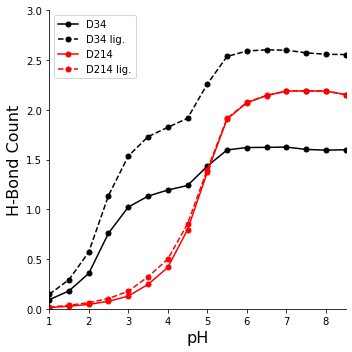

In [9]:
# Fold Cell
plt.close('all')
fig, axes = plt.subplots(figsize= (5,5))
fig.set_facecolor('white')

legends = ["D34", "D34 lig.", "D214", "D214 lig."]

axes.set_xlabel('pH', fontsize=16)
axes.set_ylabel('H-Bond Count', fontsize=16)
axes.plot([x[0] for x in D34_final], [y[1] for y in D34_final], 'ko-', markersize = 5)
axes.plot([x[0] for x in D34_lig_final], [y[1] for y in D34_lig_final], 'ko--', markersize = 5)
axes.plot([x[0] for x in D214_final], [y[1] for y in D214_final], 'ro-', markersize = 5)
axes.plot([x[0] for x in D214_lig_final], [y[1] for y in D214_lig_final], 'ro--', markersize = 5)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.legend(legends)
axes.set_ylim(0, 3.0)
axes.set_xlim(1, 8.5)


fig.tight_layout()
plt.savefig("apo_hbond_count.pdf")
plt.show()

In [10]:
#for a, b in zip(D34_final, D34_lig_final):
#    print(f'{a[0]}, {b[1]-a[1]:0.1f}, {b[1]:0.1f}')

In [11]:
#for a, b in zip(D214_final, D214_lig_final):
#    print(f'{a[0]}, {b[1]:0.1f}')

Save Data

In [13]:
with open('../data/hbond_count_holo_D34_D214.dat', 'w') as o:
    o.write(f'# pH, D34 prot-prot, D34 prot&lig-prot, D214 prot-prot, D214 prot&lig-prot \n')
    for D34, D34_lig, D214, D214_lig in zip(D34_final, D34_lig_final, D214_final, D214_lig_final):
        o.write(f'{D34[0]:0.1f} {D34[1]:0.2f} {D34_lig[1]:0.2f} {D214[1]:0.2f} {D214_lig[1]:0.2f} \n')